In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 1
Calculate time gaps between inputs

In [1]:
import sqlite3
import datetime
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time as t
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

from tabulate import tabulate

#USERS 6 AND 12 HAD CORRUPTED DATA

def encode_OHE(df):
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(df)

    new_feats = encoder.transform(df)
    new_cols = pd.DataFrame(new_feats, dtype=int)
    new_df = pd.concat([df, new_cols], axis=1)
    new_df.drop('id', axis=1, inplace=True)
    return new_df

def binary_search(arr, x, isStart):
    low = 0
    high = len(arr) - 1
    mid = 0
    while low <= high:
        mid = (high + low) // 2
        if arr.iloc[mid] < x:
            low = mid + 1
        elif arr.iloc[mid] > x:
            high = mid - 1
        else:
            return mid
    
    return mid + 1

def find_delta(dictionary):
    current = None
    previous = None
    gaps = {}

    for value in dictionary.values():
        for i in range(0, len(value) - 1):
            #print(gaps)
            if i == 0 and previous == None:
                previous = value[i]['dateTime']
                #print("check1")
            else:    
                current = value[i]['dateTime']
                previous = value[i - 1]['dateTime']
                delta = round((current - previous).total_seconds(), 3)
                #print("check2, ", delta)
                if delta < 3600:
                    if delta in gaps:
                        gaps[delta] += 1
                        #print("check3, ", delta)
                    else:
                        gaps[delta] = 1
                        #print("check4, ", delta)
            #print(f"Current is: {current}. Previous is: {previous}")
            #print(delta)
    #print(gaps)
    return gaps

def filter_present(dictionary, recorded_images):
    return dict(filter(lambda element: recorded_images.iloc[element[0]]['state'] == "Present", dictionary.items()))

def filter_non_empty(dictionary):
    return dict(filter(lambda element: len(element[1]) != 0, dictionary.items()))

def get_data(id):
    con = sqlite3.connect(id)
    
    cur = con.cursor()
    input_signals = []
    recorded_images = []
    matched = []
    
    input_signals = pd.read_sql('SELECT * FROM signals;', con)
    input_signals['dateTime']= pd.to_datetime(input_signals['dateTime'])
    
    recorded_images = pd.read_sql('SELECT id, dateTime, state FROM images;', con)
    recorded_images['dateTime']= pd.to_datetime(recorded_images['dateTime'])

    con.close()
    

    results = {}
    current = recorded_images.iloc[0]['dateTime']
    next = recorded_images.iloc[1]['dateTime']
    
    input_signals = input_signals.sort_values('dateTime')


    for i in range(0, len(recorded_images) - 2):
        fromIndex = binary_search(input_signals['dateTime'], current, True)
        toIndex = binary_search(input_signals['dateTime'], next, False)
        results[recorded_images['id'].iloc[i]] = [input_signals.iloc[x] for x in range(fromIndex, toIndex)]
        current = next
        next = recorded_images.iloc[i+2]['dateTime']


    non_empty = filter_non_empty(results)
    present = filter_present(results, recorded_images)
    present_and_non_empty = filter_non_empty(present)
    #print("non-empty")
    #print(find_delta(non_empty))
    #print("present_and_non_empty")
    #print(find_delta(present_and_non_empty))
    
    #answer = [{}, {}]
    answer = [find_delta(non_empty), find_delta(present_and_non_empty)]
    #print(answer)
    return answer

time_results = {}
for i in range(1, 16):
    if i != 6 and i != 12 and i != 9:
        print(i)
        time_results['user'+str(i)] = get_data('user'+str(i)+'.sqlite')
        #print(time_results['user'+str(i)])

1
2
3
4
5
7
8
10
11
13
14
15


# Part 2
Visualize data collected

user 1
absent+present


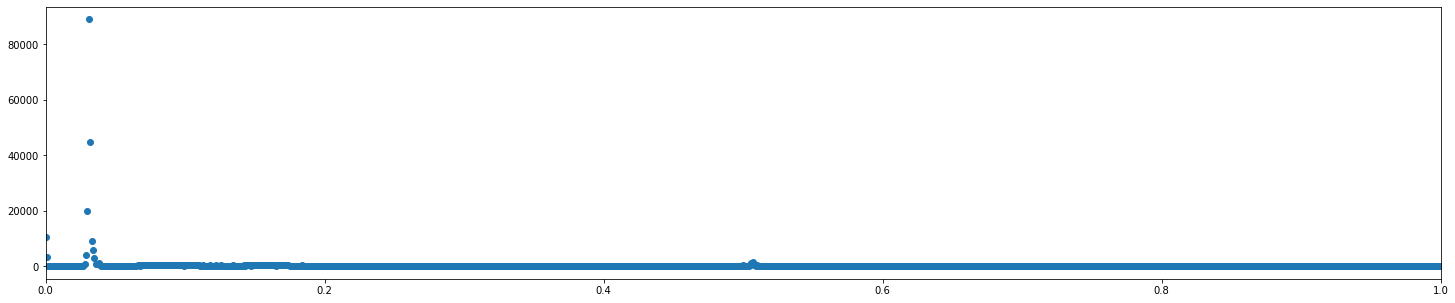

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


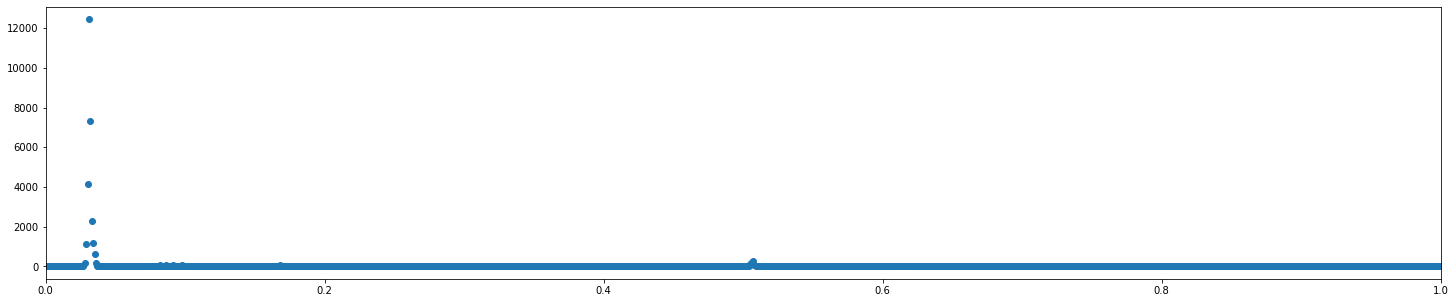

{'nobs': 163771, 'minmax': (1, 66), 'mean': 1.4803780889168412, 'variance': 6.677313885258195, 'skewness': 10.630486606828525, 'kurtosis': 144.97719427854952, 'user': 'user1'}
user 2
absent+present


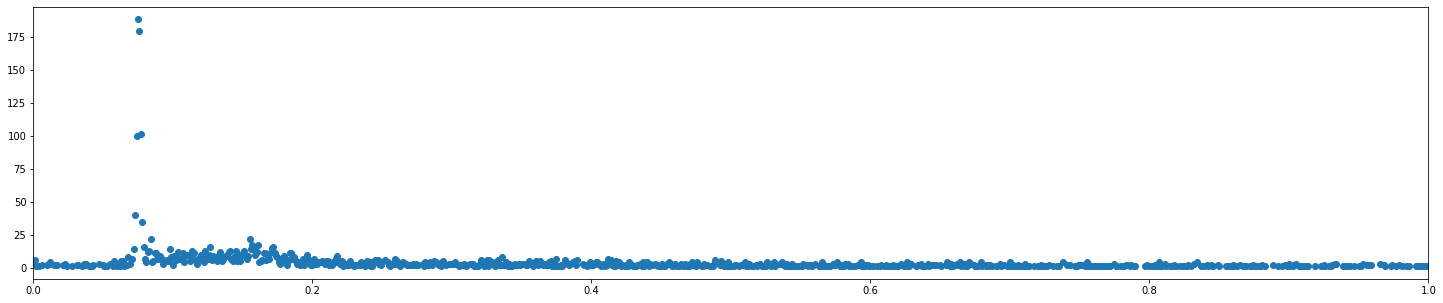

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


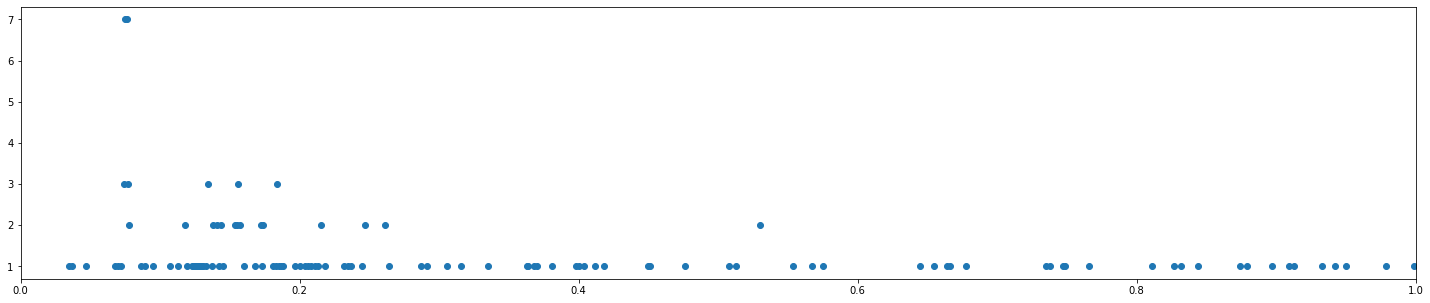

{'nobs': 1273, 'minmax': (1, 3), 'mean': 1.0549882168106834, 'variance': 0.06301165473526114, 'skewness': 4.9009538034664315, 'kurtosis': 25.704093204783497, 'user': 'user2'}
user 3
absent+present


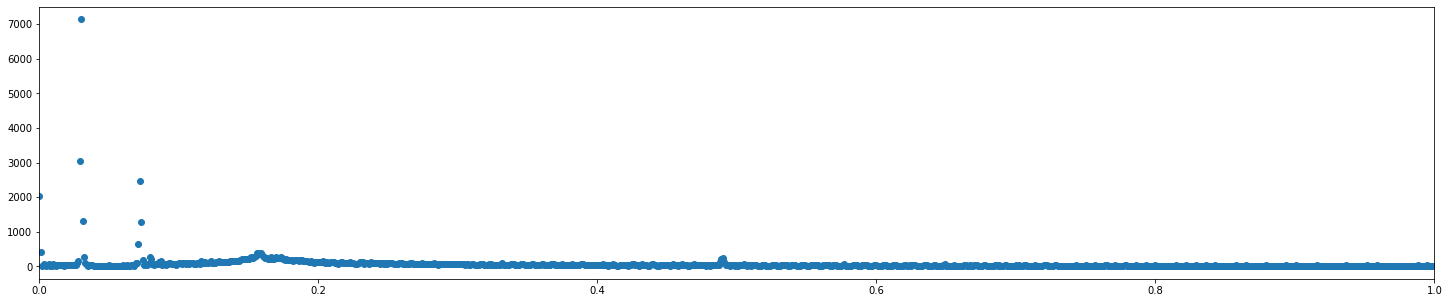

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


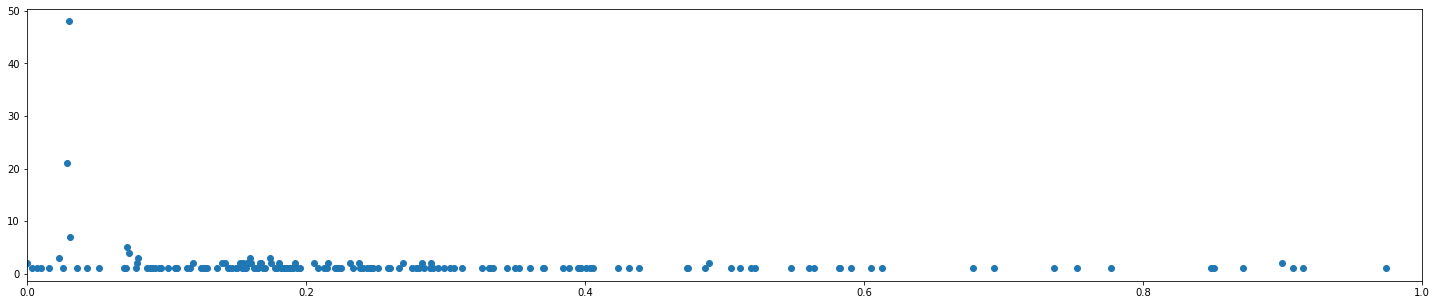

{'nobs': 41801, 'minmax': (1, 33), 'mean': 1.3564268797397192, 'variance': 2.359822868869807, 'skewness': 8.184028348816307, 'kurtosis': 89.64482740548137, 'user': 'user3'}
user 4
absent+present


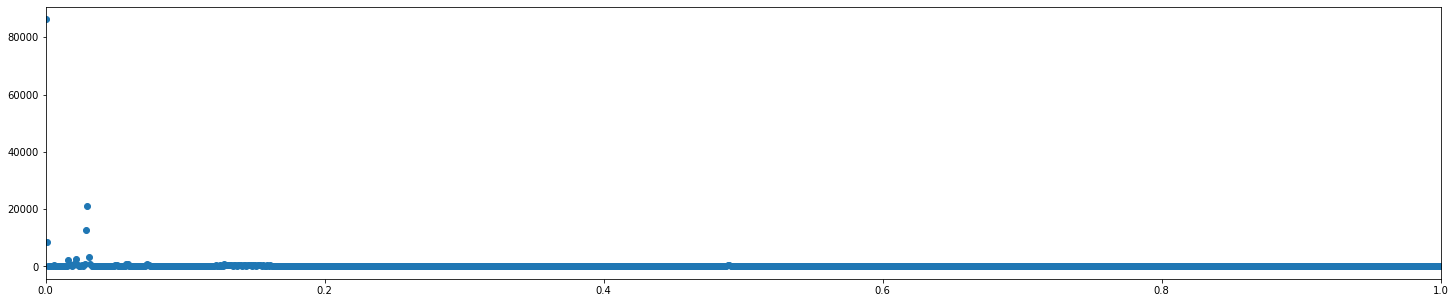

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


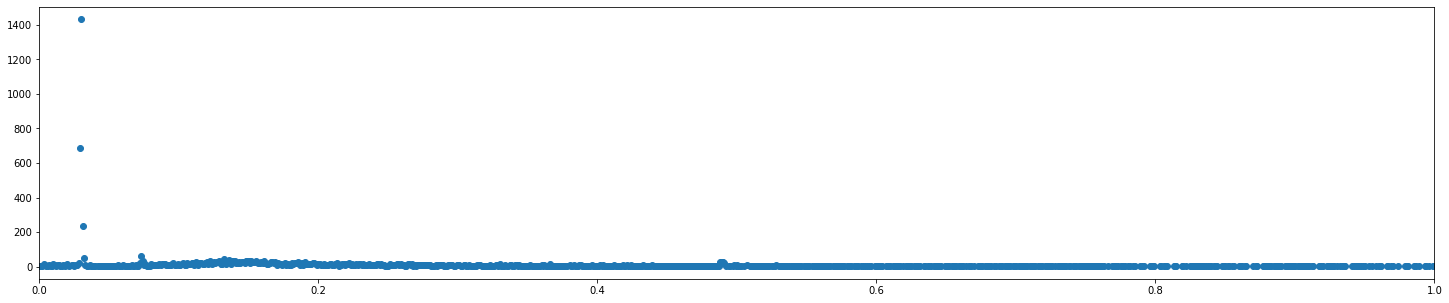

{'nobs': 46228, 'minmax': (1, 36), 'mean': 1.4040624729601108, 'variance': 2.6757850837730786, 'skewness': 7.460116134806118, 'kurtosis': 73.19847047991172, 'user': 'user4'}
user 5
absent+present


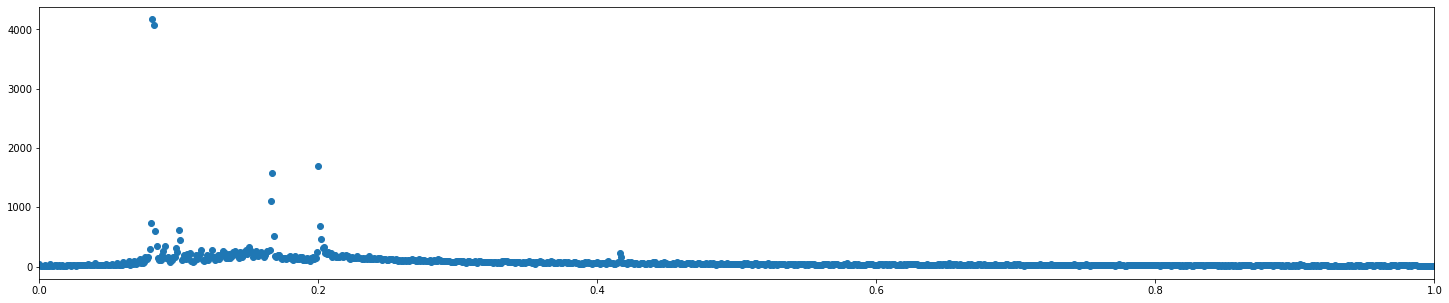

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


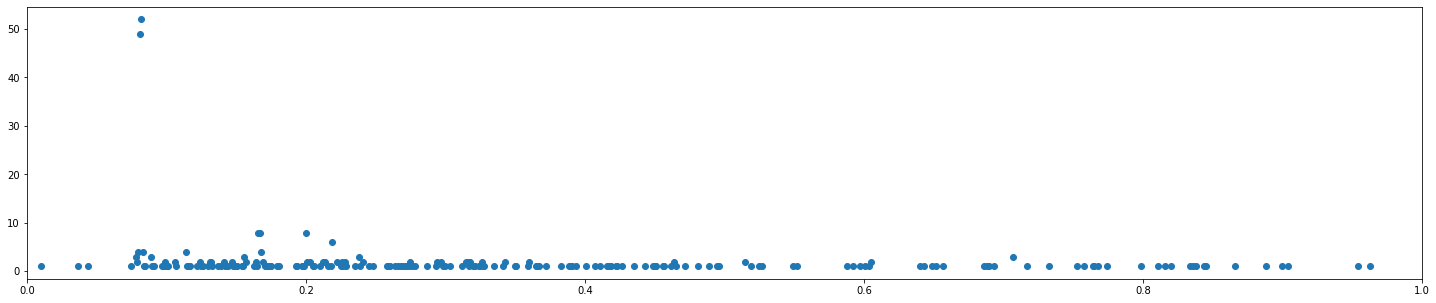

{'nobs': 25957, 'minmax': (1, 25), 'mean': 1.4853026158646994, 'variance': 2.7055649155475567, 'skewness': 5.6046831131252235, 'kurtosis': 39.25923154937843, 'user': 'user5'}
user 7
absent+present


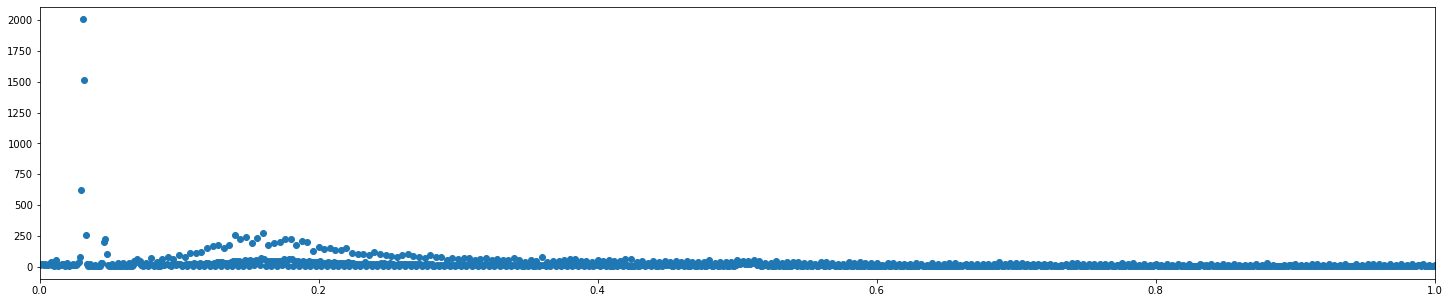

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


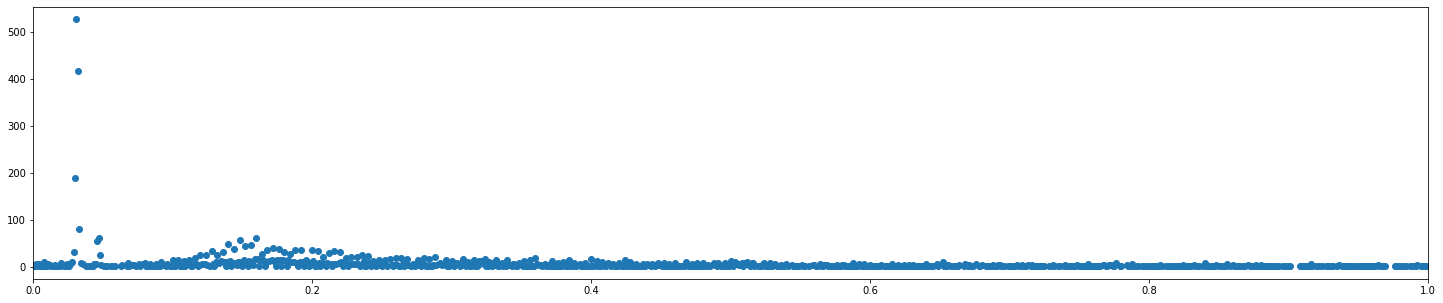

{'nobs': 26633, 'minmax': (1, 19), 'mean': 1.1476363909435663, 'variance': 0.6697016262695213, 'skewness': 9.492186832284395, 'kurtosis': 118.30724329948288, 'user': 'user7'}
user 8
absent+present


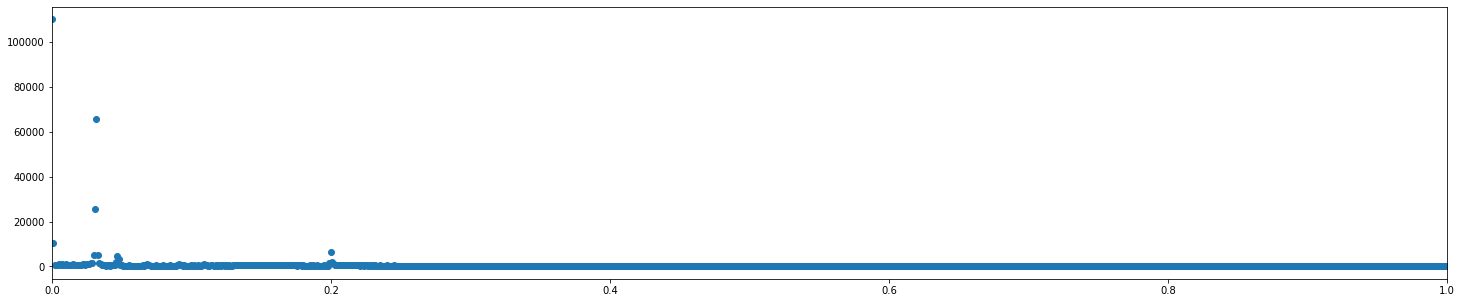

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


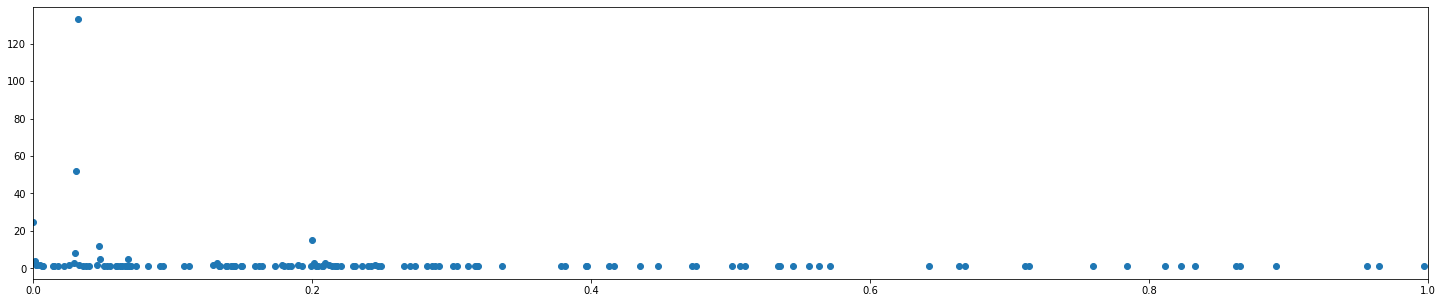

{'nobs': 21317, 'minmax': (1, 27), 'mean': 1.412393864052165, 'variance': 3.0456767470968953, 'skewness': 6.94940676420186, 'kurtosis': 58.031750111047906, 'user': 'user8'}
user 10
absent+present


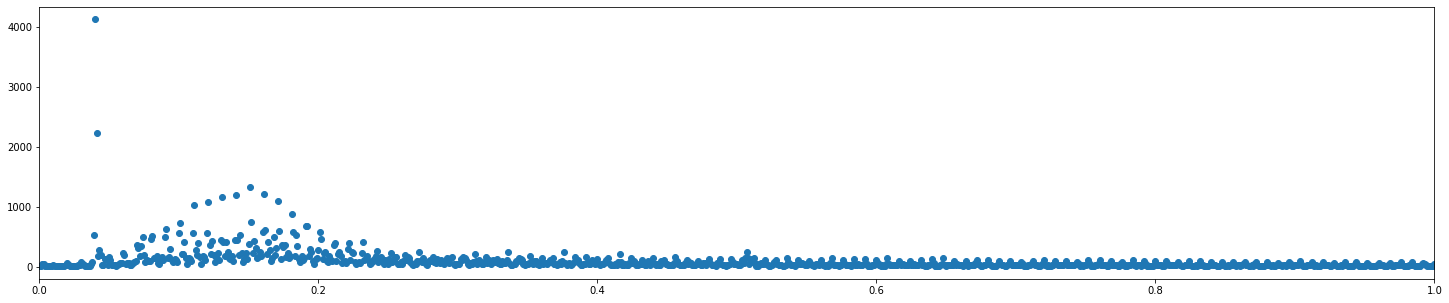

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


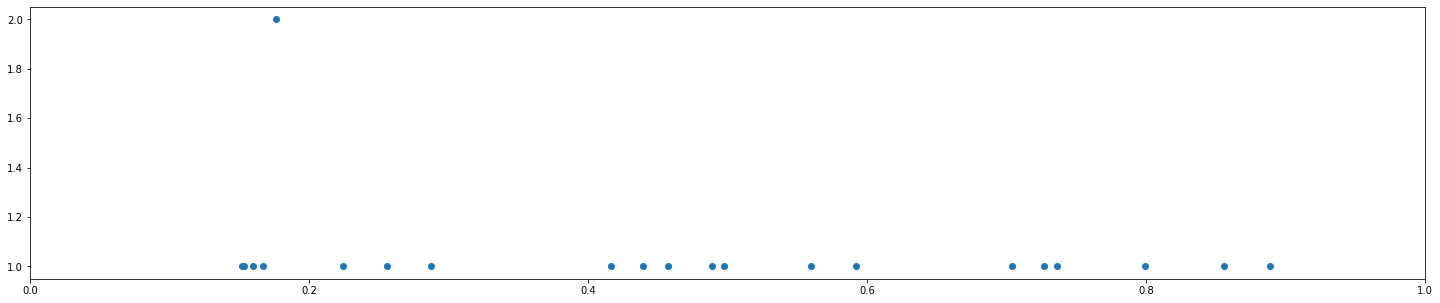

{'nobs': 109459, 'minmax': (1, 77), 'mean': 1.2530171114298505, 'variance': 3.1063027928424622, 'skewness': 17.25955094010226, 'kurtosis': 444.4597655824417, 'user': 'user10'}
user 11
absent+present


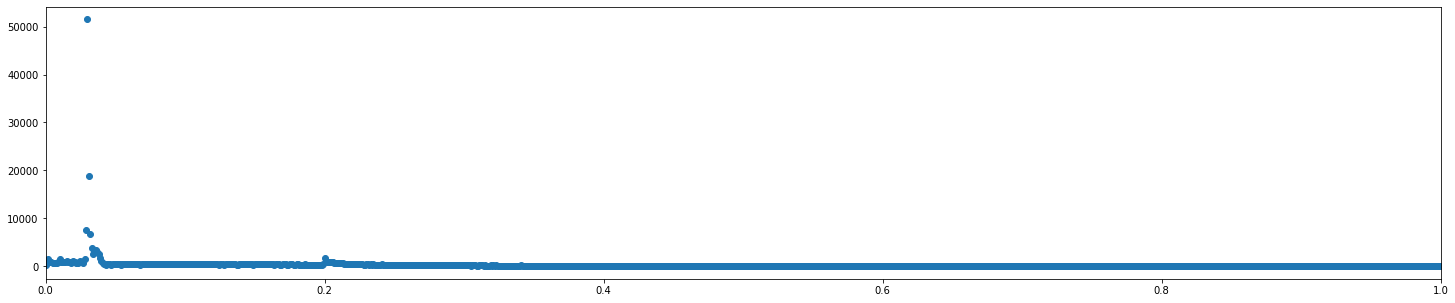

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


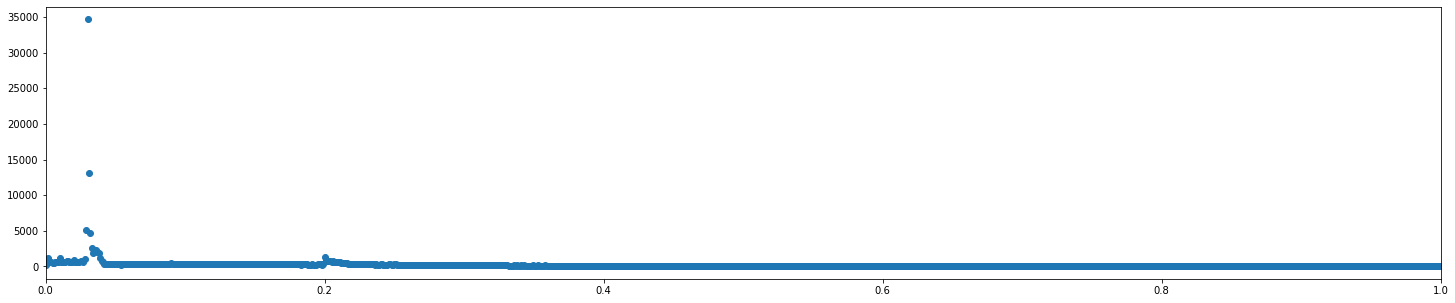

{'nobs': 66860, 'minmax': (1, 15), 'mean': 1.0559826503140892, 'variance': 0.21749438280372674, 'skewness': 13.008400225448435, 'kurtosis': 215.56008281884775, 'user': 'user11'}
user 13
absent+present


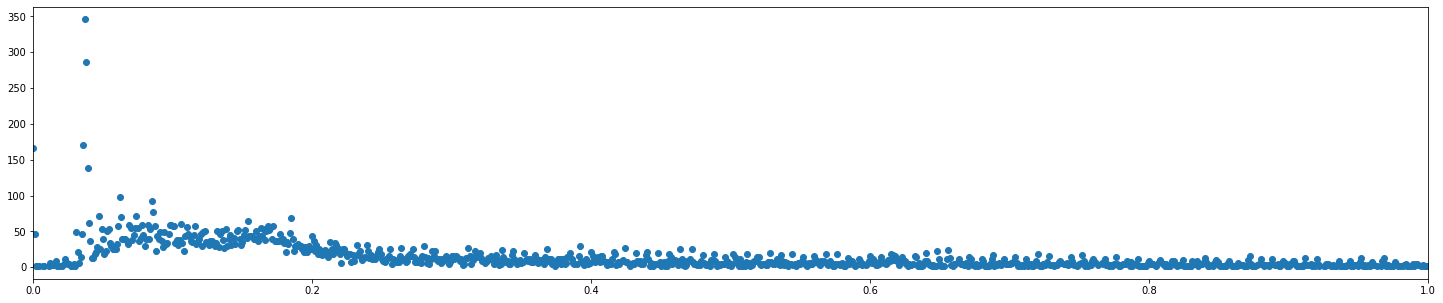

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


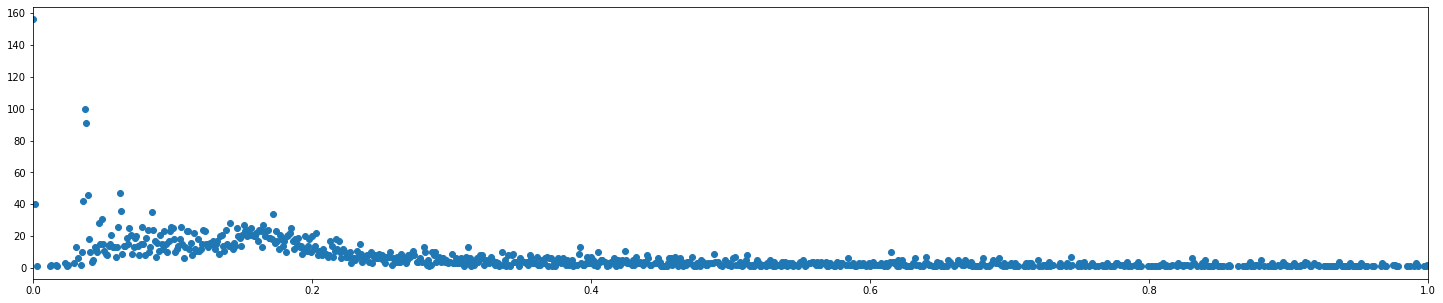

{'nobs': 37619, 'minmax': (1, 15), 'mean': 1.039740556633616, 'variance': 0.11434919102112673, 'skewness': 14.401202942165654, 'kurtosis': 298.40937904169505, 'user': 'user13'}
user 14
absent+present


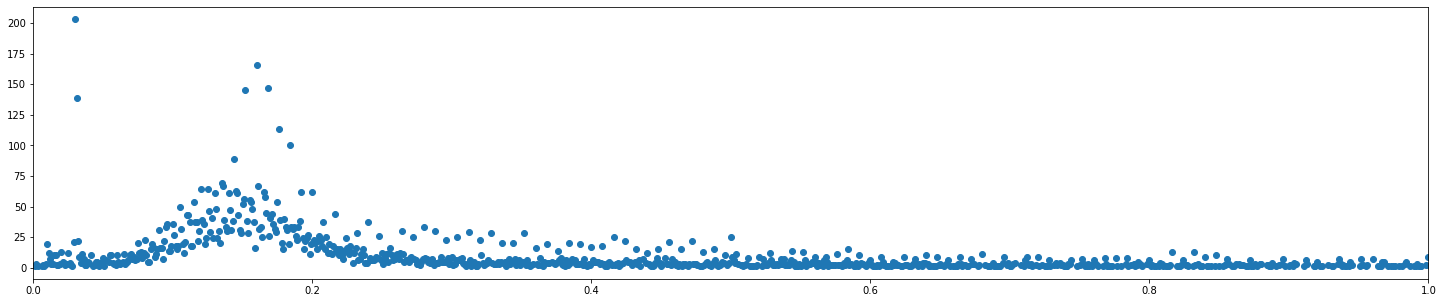

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


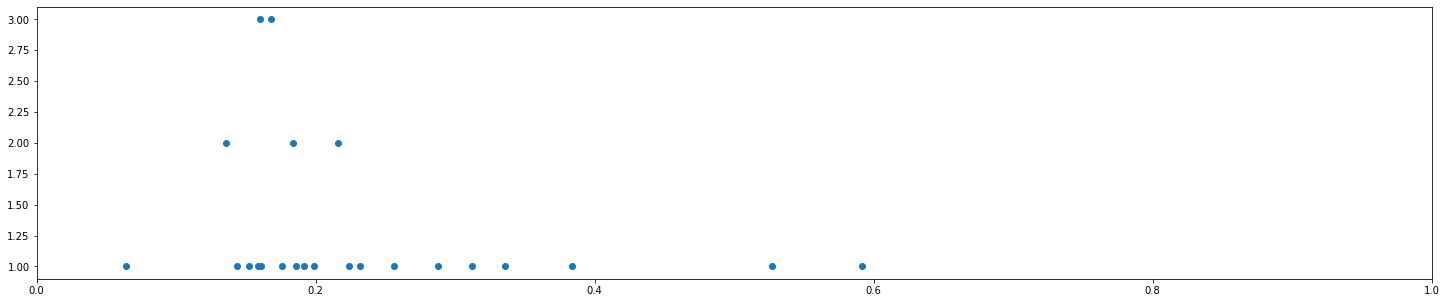

{'nobs': 1238, 'minmax': (1, 10), 'mean': 1.197092084006462, 'variance': 0.47850406750398006, 'skewness': 5.816379709182737, 'kurtosis': 47.51347825239052, 'user': 'user14'}


In [10]:
descriptive_statistics = []

for i in range(1, 15):
    if i != 6 and i != 12 and i != 9:
        print("user", i)
        print("absent+present")
        #print(time_results['user'+str(i)][0].items())
        listed_gaps = sorted(time_results['user'+str(i)][0].items())
        x, y = zip(*listed_gaps) # plotting
        ticks = x[1::2]
        plt.figure(figsize=(25, 5))
        plt.xlim([0.0, 1.0])
        plt.scatter(x, y, marker='o')
        plt.show()
        k2, p = stats.normaltest(y)
        alpha = 1e-3
        print("p = {:g}".format(p))
        if p < alpha:  # null hypothesis: x comes from a normal distribution
            print("The null hypothesis can be rejected")
        else:
            print("The null hypothesis cannot be rejected")
        print("only present")
        print(type(time_results['user'+str(i)][0].items()))
        listed_gaps = sorted(time_results['user'+str(i)][1].items())
        x2, y2 = zip(*listed_gaps) # plotting
        ticks = x[1::2]
        plt.figure(figsize=(25, 5))
        plt.xlim([0.0, 1.0])
        plt.scatter(x2, y2, marker='o')
        plt.show()
        describe_list = []
        for k, v in time_results['user'+str(i)][0].items():
            helper_list = [v]*int(k)
            describe_list.extend(helper_list)
        for_describe = [item for item in describe_list if item > 0]
        statistics = stats.describe(for_describe)._asdict()
        statistics["user"] = 'user'+str(i)
        print(statistics)
        descriptive_statistics.append(statistics)
# for i in range(3):
#     rec = get_data('signals'+str(i)+'.sqlite')
#     print("user",9)
#     print("absent+present")
#     listed_gaps = sorted(rec[0].items())
#     x, y = zip(*listed_gaps) # plotting
#     ticks = x[1::2]
#     plt.figure(figsize=(25, 5))
#     plt.scatter(x, y, marker='o')
#     plt.show()
#     print("only present")
#     listed_gaps = sorted(rec[1].items())
#     x2, y2 = zip(*listed_gaps)
#     ticks = x2[1::2]
#     plt.figure(figsize=(25, 5))
#     plt.scatter(x2, y2, marker='o')
#     plt.show()

# Part 3
Compare users

In [21]:
sorted_by_mean = sorted(descriptive_statistics, key=lambda item: item['mean'])
print("SORTED BY MEAN")
for item in sorted_by_mean:
    print(item['user'], ":", item['mean'])

SORTED BY MEAN
user13 : 1.039740556633616
user2 : 1.0549882168106834
user11 : 1.0559826503140892
user7 : 1.1476363909435663
user14 : 1.197092084006462
user10 : 1.2530171114298505
user3 : 1.3564268797397192
user4 : 1.4040624729601108
user8 : 1.412393864052165
user1 : 1.4803780889168412
user5 : 1.4853026158646994


In [22]:
sorted_by_variance = sorted(descriptive_statistics, key=lambda item: item['variance'])
print("SORTED BY VARIANCE")
for item in sorted_by_variance:
    print(item['user'], ":", item['variance'])

SORTED BY VARIANCE
user2 : 0.06301165473526114
user13 : 0.11434919102112673
user11 : 0.21749438280372674
user14 : 0.47850406750398006
user7 : 0.6697016262695213
user3 : 2.359822868869807
user4 : 2.6757850837730786
user5 : 2.7055649155475567
user8 : 3.0456767470968953
user10 : 3.1063027928424622
user1 : 6.677313885258195


In [23]:
sorted_by_max = sorted(descriptive_statistics, key=lambda item: item['minmax'][1])
print("SORTED BY MAX")
for item in sorted_by_max:
    print(item['user'], ":", item['minmax'])

SORTED BY MAX
user2 : (1, 3)
user14 : (1, 10)
user11 : (1, 15)
user13 : (1, 15)
user7 : (1, 19)
user5 : (1, 25)
user8 : (1, 27)
user3 : (1, 33)
user4 : (1, 36)
user1 : (1, 66)
user10 : (1, 77)
